In [2]:
import numpy as np
from qiskit import QuantumCircuit, BasicAer, execute, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.extensions import Initialize

In [17]:
qr = QuantumRegister(3)
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [18]:
def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a, b)

In [19]:
create_bell_pair(teleportation_circuit, 1, 2)

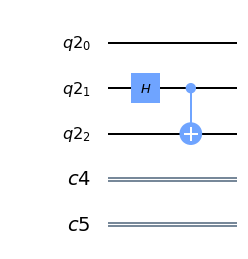

In [20]:
teleportation_circuit.draw(output='mpl')

In [21]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

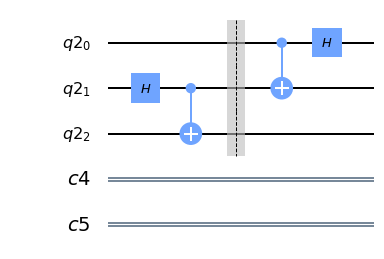

In [22]:
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

In [23]:
def measure_and_send(qc, a, b):
    qc.measure(a, 0)
    qc.measure(b, 1)

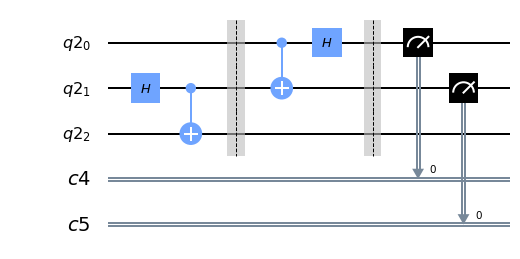

In [24]:
teleportation_circuit.barrier()
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

In [25]:
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

In [26]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)

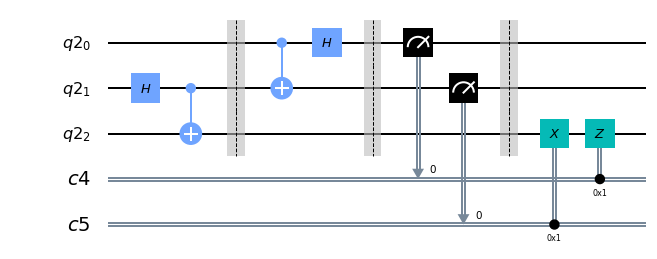

In [27]:
teleportation_circuit.draw(output='mpl')

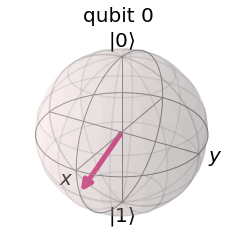

In [29]:
from math import sqrt
psi = [1/sqrt(3), sqrt(2)/sqrt(3)]
plot_bloch_multivector(psi)

In [47]:
init_gate = Initialize(psi)
init_gate.label = 'init'

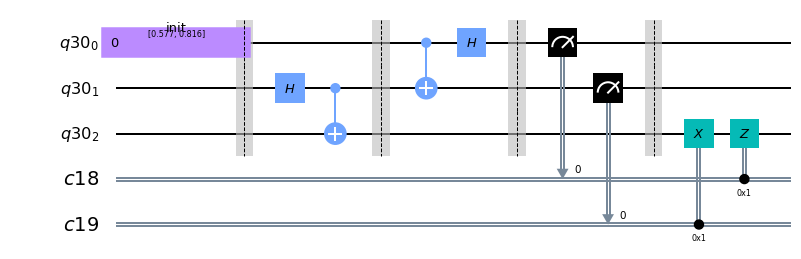

In [48]:
qr = QuantumRegister(3)   
crz = ClassicalRegister(1) 
crx = ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx)

qc.append(init_gate, [0])
qc.barrier()

create_bell_pair(qc, 1, 2)
qc.barrier()

alice_gates(qc, 0, 1)

qc.barrier()
measure_and_send(qc, 0, 1)

qc.barrier()
bob_gates(qc, 2, crz, crx)

qc.draw(output='mpl')

In [49]:
backend = BasicAer.get_backend('statevector_simulator')
state = execute(qc, backend).result().get_statevector()

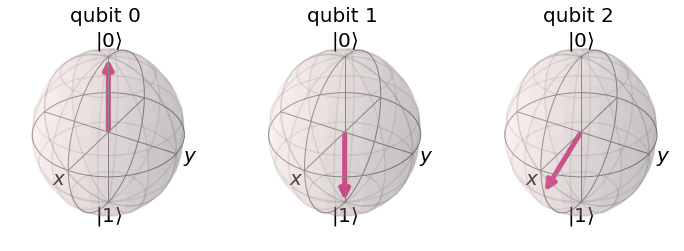

In [52]:
plot_bloch_multivector(state)

In [54]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [55]:
qc.append(inverse_init_gate, [2])

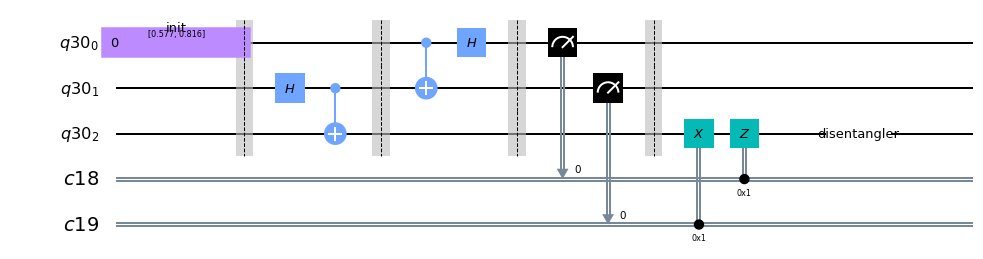

In [56]:
qc.draw(output='mpl')

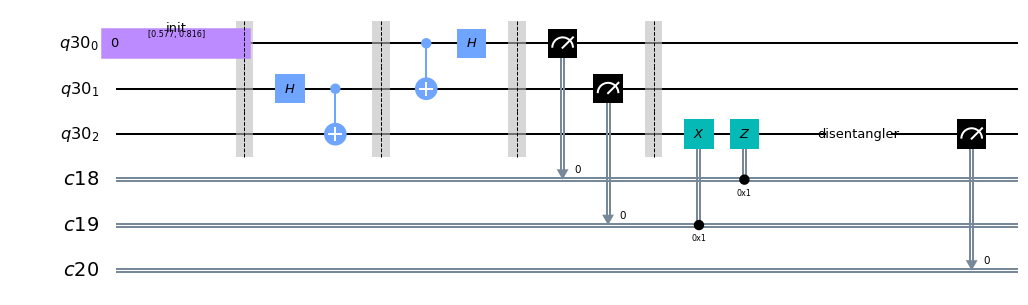

In [57]:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2, 2)
qc.draw(output='mpl')

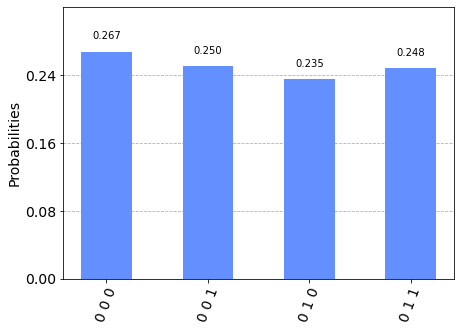

In [60]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(result)

In [61]:
#Applying the same on a real QUantum Computer

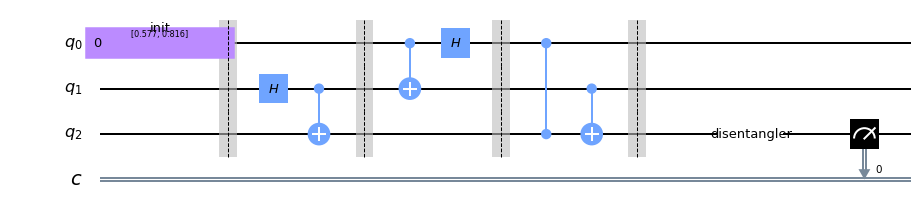

In [65]:
qc = QuantumCircuit(3, 1)

qc.append(init_gate, [0])

qc.barrier()
create_bell_pair(qc, 1, 2)

qc.barrier()
alice_gates(qc, 0, 1)

qc.barrier()
qc.cz(0, 2)
qc.cx(1, 2)

qc.barrier()
qc.append(inverse_init_gate, [2])

qc.measure(2, 0)
qc.draw(output='mpl')

In [68]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [67]:
IBMQ.save_account('df2b4baba5abfb06d4861484e5bdb25af1681fbb2a0bda119ce4427e3775c0dc651a9116aebf14e168cae3a4857efdbd87ab4d6a1e3a9021ed408786822c21a9')

In [74]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits > 3 and
                                      not b.configuration().simulator and b.status().operational == True))
job_exp = execute(qc, backend=backend, shots=8192)

In [75]:
backend

<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>

{'0': 7298, '1': 894}


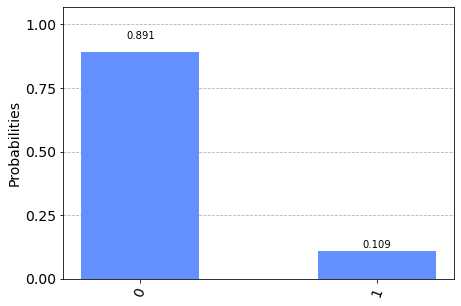

In [76]:
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

In [77]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  10.9130859375 %
